In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import layers, models, optimizers
from keras.applications import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Note the following code as been built in collaboration with GPT-4.
# OpenAI. (2023). ChatGPT (Mar 23 version) [Large language model]. https://chat.openai.com/c/b1498a7b-afc7-49e7-bd55-b90f0b9922b3

In [ ]:
drive.mount('/content/drive')

# Load the CSV files
metadata_df = pd.read_csv('/content/drive/My Drive/Project/archive/HAM10000_metadata.csv')

# Add the .jpg file extension to the filenames in the dataframe
metadata_df['image_id'] = metadata_df['image_id'].apply(lambda x: f"{x}.jpg")

# Define image directories
data_dir_1 = '/content/drive/My Drive/Project/archive/HAM10000_images_part_1'
data_dir_2 = '/content/drive/My Drive/Project/archive/HAM10000_images_part_2'

# Merge the two image directories
metadata_df['image_path'] = metadata_df['image_id'].apply(lambda x: os.path.join(data_dir_1, x) if os.path.exists(os.path.join(data_dir_1, x)) else os.path.join(data_dir_2, x))

# Create a stratified train and validation split 
train_df, valid_df = train_test_split(metadata_df, test_size=0.15, random_state=47, stratify=metadata_df['dx'])

# Reset the index of the resulting dataframes
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)


Mounted at /content/drive


In [ ]:
# Function to load and preprocess images
def load_images(image_paths, target_size):
    images = []
    for img_path in image_paths:
        img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

class OversamplingDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, datagen, target_size, batch_size, oversampler, undersampler):
        self.original_dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.datagen = datagen
        self.target_size = target_size
        self.batch_size = batch_size
        self.oversampler = oversampler
        self.undersampler = undersampler
        self.all_classes = np.unique(dataframe[y_col])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __data_generation(self, image_paths, labels):
        X = load_images(image_paths, target_size=self.target_size)
        y = pd.get_dummies(labels).reindex(columns=self.all_classes, fill_value=0).values

        X_augmented = np.zeros((len(X), *self.target_size, 3))
        for i, x in enumerate(X):
            x = self.datagen.random_transform(x)
            x = self.datagen.standardize(x)
            X_augmented[i] = x

        return X_augmented, y

    def __getitem__(self, idx):
        batch_df = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df[self.x_col].values, batch_df[self.y_col].values)

        return X, y

    def on_epoch_end(self):
        X, y = self.undersampler.fit_resample(self.original_dataframe[[self.x_col]], self.original_dataframe[self.y_col])
        X, y = self.oversampler.fit_resample(X, y)
        self.dataframe = pd.concat([X, y], axis=1)
        self.n = len(self.dataframe)
        self.dataframe = shuffle(self.dataframe)

# Set the batch size
batchSize = 32

sampling_strategy = {
    'nv': 1000,
    'mel': 946,
    'bkl': 934,
    'bcc': 437,
    'akiec': 278,
    'vasc': 120,
    'df': 98 
}

y_train = train_df['dx'].values
unique_classes = np.unique(y_train)
class_weights_list = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_list)}

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=359,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

# Create the custom train and validation generators
ros = RandomOverSampler(random_state=47)
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=47)

train_generator = OversamplingDataGenerator(dataframe=train_df,
                                            x_col='image_path',
                                            y_col='dx',
                                            datagen=train_datagen,
                                            target_size=(299, 299),
                                            batch_size=batchSize,
                                            oversampler=ros,
                                            undersampler=rus)

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                                    x_col='image_path',
                                                    y_col='dx',
                                                    target_size=(299, 299),
                                                    batch_size=batchSize,
                                                    class_mode='categorical')

# Load Inception v3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# We fine-tune all layer
for layer in base_model.layers:
    layer.trainable = True

# Remove the last layer
x = base_model.output

# Set number of class to 7 as we only have 7 labels in our data
number_of_classes = 7

# Add out final layer for classification
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
predictions = layers.Dense(number_of_classes, activation='softmax')(x)

# Modifying Model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Define the loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) - \
               tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))
    return focal_loss_fixed

# Compile the model with RMSProp optimizer and the specified parameters
model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

# Number of epochs
total_epochs = 60

# All callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.Adam', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // train_generator.batch_size,
                    epochs=total_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n // valid_generator.batch_size,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, model_checkpoint])

Found 1503 validated image filenames belonging to 7 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/60
218/218 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.1714

218/218 [==============================] - 1473s 7s/step - loss: 0.2688 - accuracy: 0.1714 - val_loss: 0.0519 - val_accuracy: 0.1963
Epoch 2/60
218/218 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.2117

218/218 [==============================] - 274s 1s/step - loss: 0.2518 - accuracy: 0.2117 - val_loss: 0.0483 - val_accuracy: 0.3247
Epoch 3/60
218/218 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.2566

218/218 [==============================] - 270s 1s/step - loss: 0.2372 - accuracy: 0.2566 - val_loss: 0.0454 - val_accuracy: 0.3995
Epoch 4/60
218/218 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.2956

218/218 [==============================] - 274s 1s/step - loss: 0.2241 - accuracy: 0.2956 - val_loss: 0.0433 - val_accuracy: 0.4341
Epoch 5/60
218/218 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.3308

218/218 [==============================] - 268s 1s/step - loss: 0.2158 - accuracy: 0.3308 - val_loss: 0.0412 - val_accuracy: 0.4742
Epoch 6/60
218/218 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.3683

218/218 [==============================] - 268s 1s/step - loss: 0.2043 - accuracy: 0.3683 - val_loss: 0.0390 - val_accuracy: 0.5034
Epoch 7/60
218/218 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.4074

218/218 [==============================] - 269s 1s/step - loss: 0.1936 - accuracy: 0.4074 - val_loss: 0.0369 - val_accuracy: 0.5197
Epoch 8/60
218/218 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.4449

218/218 [==============================] - 267s 1s/step - loss: 0.1832 - accuracy: 0.4449 - val_loss: 0.0349 - val_accuracy: 0.5428
Epoch 9/60
218/218 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.4677

218/218 [==============================] - 268s 1s/step - loss: 0.1766 - accuracy: 0.4677 - val_loss: 0.0334 - val_accuracy: 0.5639
Epoch 10/60
218/218 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.4898

218/218 [==============================] - 269s 1s/step - loss: 0.1700 - accuracy: 0.4898 - val_loss: 0.0312 - val_accuracy: 0.5836
Epoch 11/60
218/218 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.5072

218/218 [==============================] - 268s 1s/step - loss: 0.1636 - accuracy: 0.5072 - val_loss: 0.0301 - val_accuracy: 0.6005
Epoch 12/60
218/218 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.5299

218/218 [==============================] - 267s 1s/step - loss: 0.1583 - accuracy: 0.5299 - val_loss: 0.0292 - val_accuracy: 0.6073
Epoch 13/60
218/218 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.5497

218/218 [==============================] - 266s 1s/step - loss: 0.1525 - accuracy: 0.5497 - val_loss: 0.0282 - val_accuracy: 0.6148
Epoch 14/60
218/218 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.5538

218/218 [==============================] - 266s 1s/step - loss: 0.1486 - accuracy: 0.5538 - val_loss: 0.0282 - val_accuracy: 0.6114
Epoch 15/60
218/218 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.5752

218/218 [==============================] - 266s 1s/step - loss: 0.1423 - accuracy: 0.5752 - val_loss: 0.0270 - val_accuracy: 0.6243
Epoch 16/60
218/218 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.5871

218/218 [==============================] - 266s 1s/step - loss: 0.1382 - accuracy: 0.5871 - val_loss: 0.0263 - val_accuracy: 0.6318
Epoch 17/60
218/218 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.5950

218/218 [==============================] - 268s 1s/step - loss: 0.1350 - accuracy: 0.5950 - val_loss: 0.0256 - val_accuracy: 0.6372
Epoch 18/60
218/218 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.6145

218/218 [==============================] - 270s 1s/step - loss: 0.1304 - accuracy: 0.6145 - val_loss: 0.0250 - val_accuracy: 0.6488
Epoch 19/60
218/218 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.6270

218/218 [==============================] - 272s 1s/step - loss: 0.1281 - accuracy: 0.6270 - val_loss: 0.0245 - val_accuracy: 0.6508
Epoch 20/60
218/218 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.6359

218/218 [==============================] - 270s 1s/step - loss: 0.1232 - accuracy: 0.6359 - val_loss: 0.0238 - val_accuracy: 0.6624
Epoch 21/60
218/218 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.6379

218/218 [==============================] - 269s 1s/step - loss: 0.1225 - accuracy: 0.6379 - val_loss: 0.0232 - val_accuracy: 0.6760
Epoch 22/60
218/218 [==============================] - 237s 1s/step - loss: 0.1174 - accuracy: 0.6521 - val_loss: 0.0233 - val_accuracy: 0.6671
Epoch 23/60
218/218 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.6625

218/218 [==============================] - 268s 1s/step - loss: 0.1134 - accuracy: 0.6625 - val_loss: 0.0227 - val_accuracy: 0.6705
Epoch 24/60
218/218 [==============================] - 237s 1s/step - loss: 0.1143 - accuracy: 0.6566 - val_loss: 0.0228 - val_accuracy: 0.6678
Epoch 25/60
218/218 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.6768

218/218 [==============================] - 268s 1s/step - loss: 0.1096 - accuracy: 0.6768 - val_loss: 0.0223 - val_accuracy: 0.6800
Epoch 26/60
218/218 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.6749

218/218 [==============================] - 270s 1s/step - loss: 0.1067 - accuracy: 0.6749 - val_loss: 0.0218 - val_accuracy: 0.6841
Epoch 27/60
218/218 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.6883

218/218 [==============================] - 269s 1s/step - loss: 0.1059 - accuracy: 0.6883 - val_loss: 0.0214 - val_accuracy: 0.6834
Epoch 28/60
218/218 [==============================] - 238s 1s/step - loss: 0.1034 - accuracy: 0.6899 - val_loss: 0.0218 - val_accuracy: 0.6841
Epoch 29/60
218/218 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.7041

218/218 [==============================] - 271s 1s/step - loss: 0.1018 - accuracy: 0.7041 - val_loss: 0.0211 - val_accuracy: 0.6929
Epoch 30/60
218/218 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.7038

218/218 [==============================] - 268s 1s/step - loss: 0.1001 - accuracy: 0.7038 - val_loss: 0.0208 - val_accuracy: 0.6950
Epoch 31/60
218/218 [==============================] - 239s 1s/step - loss: 0.0955 - accuracy: 0.7184 - val_loss: 0.0208 - val_accuracy: 0.6957
Epoch 32/60
218/218 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.7171

218/218 [==============================] - 267s 1s/step - loss: 0.0954 - accuracy: 0.7171 - val_loss: 0.0205 - val_accuracy: 0.7004
Epoch 33/60
218/218 [==============================] - 241s 1s/step - loss: 0.0933 - accuracy: 0.7217 - val_loss: 0.0205 - val_accuracy: 0.6957
Epoch 34/60
218/218 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.7278

218/218 [==============================] - 272s 1s/step - loss: 0.0938 - accuracy: 0.7278 - val_loss: 0.0202 - val_accuracy: 0.7011
Epoch 35/60
218/218 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.7321

218/218 [==============================] - 270s 1s/step - loss: 0.0897 - accuracy: 0.7321 - val_loss: 0.0199 - val_accuracy: 0.7052
Epoch 36/60
218/218 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.7322

218/218 [==============================] - 269s 1s/step - loss: 0.0881 - accuracy: 0.7322 - val_loss: 0.0198 - val_accuracy: 0.7092
Epoch 37/60
218/218 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.7400

218/218 [==============================] - 268s 1s/step - loss: 0.0857 - accuracy: 0.7400 - val_loss: 0.0195 - val_accuracy: 0.7160
Epoch 38/60
218/218 [==============================] - 236s 1s/step - loss: 0.0855 - accuracy: 0.7517 - val_loss: 0.0196 - val_accuracy: 0.7113
Epoch 39/60
218/218 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.7534

218/218 [==============================] - 266s 1s/step - loss: 0.0845 - accuracy: 0.7534 - val_loss: 0.0192 - val_accuracy: 0.7133
Epoch 40/60
218/218 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.7549

218/218 [==============================] - 268s 1s/step - loss: 0.0826 - accuracy: 0.7549 - val_loss: 0.0189 - val_accuracy: 0.7181
Epoch 41/60
218/218 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.7563

218/218 [==============================] - 269s 1s/step - loss: 0.0829 - accuracy: 0.7563 - val_loss: 0.0188 - val_accuracy: 0.7181
Epoch 42/60
218/218 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.7671

218/218 [==============================] - 266s 1s/step - loss: 0.0788 - accuracy: 0.7671 - val_loss: 0.0188 - val_accuracy: 0.7201
Epoch 43/60
218/218 [==============================] - 236s 1s/step - loss: 0.0791 - accuracy: 0.7671 - val_loss: 0.0192 - val_accuracy: 0.7120
Epoch 44/60
218/218 [==============================] - 238s 1s/step - loss: 0.0792 - accuracy: 0.7691 - val_loss: 0.0189 - val_accuracy: 0.7174
Epoch 45/60
218/218 [==============================] - 235s 1s/step - loss: 0.0765 - accuracy: 0.7712 - val_loss: 0.0188 - val_accuracy: 0.7181
Epoch 46/60
218/218 [==============================] - 236s 1s/step - loss: 0.0774 - accuracy: 0.7694 - val_loss: 0.0188 - val_accuracy: 0.7174


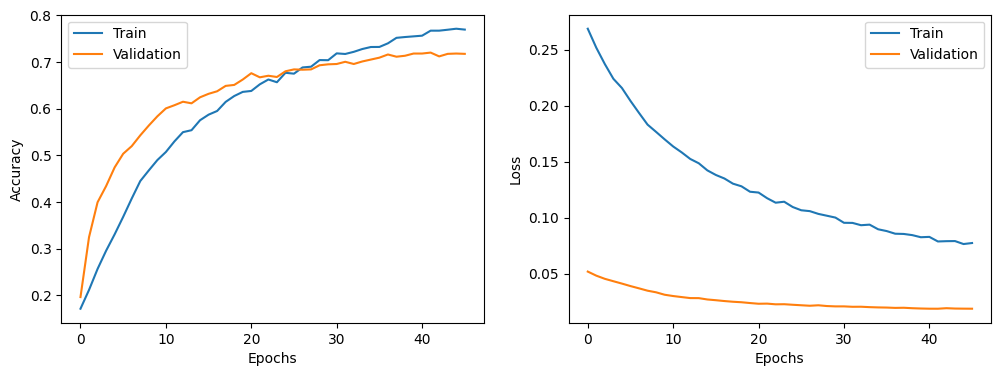

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/My Drive/Project/v3.epoch60.batch32.all.Under-Oversampler.Adam')

------------------------------------------------------------------------
We can use the following chunks to test the model on individual samples.

In [ ]:
model = load_model('/content/drive/My Drive/Project/v3.epoch60.batch32.all.Under-Oversampler.Adam', custom_objects={'focal_loss_fixed': focal_loss})

1/1 [==============================] - 0s 41ms/step


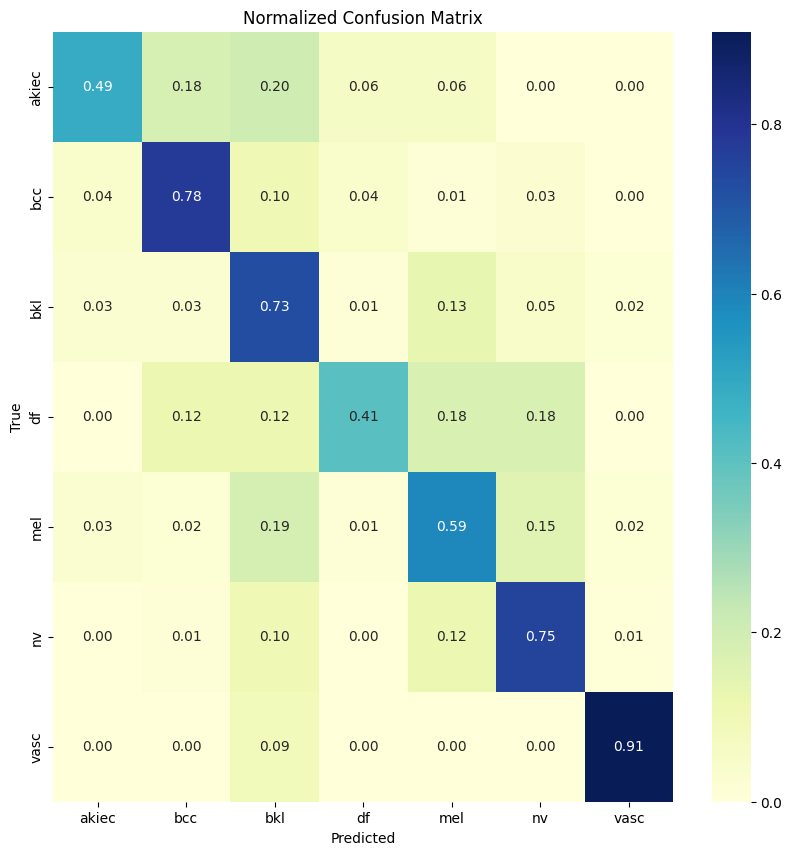

In [ ]:
malignant_classes = ['akiec', 'bcc', 'mel']
malignant_classes_indices = [0, 1, 4]

def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_labels = []
    
    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)
        y_batch_true_labels = np.argmax(y_batch_true, axis=1)
        y_batch_pred_labels = np.argmax(y_batch_pred, axis=1)
        
        true_labels.extend(y_batch_true_labels)
        predicted_labels.extend(y_batch_pred_labels)
    
    return np.array(true_labels), np.array(predicted_labels)

true_labels, predicted_labels = get_true_and_predicted_labels(model, valid_generator)

def normalize_confusion_matrix(cm):
    row_sums = cm.sum(axis=1, keepdims=True)
    return cm / row_sums

true_labels, predicted_labels = get_true_and_predicted_labels(model, valid_generator)

# Use the class_indices object from the valid_generator
class_labels = {i: label for label, i in valid_generator.class_indices.items()}

cm = confusion_matrix(true_labels, predicted_labels)
normalized_cm = normalize_confusion_matrix(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 63ms/step


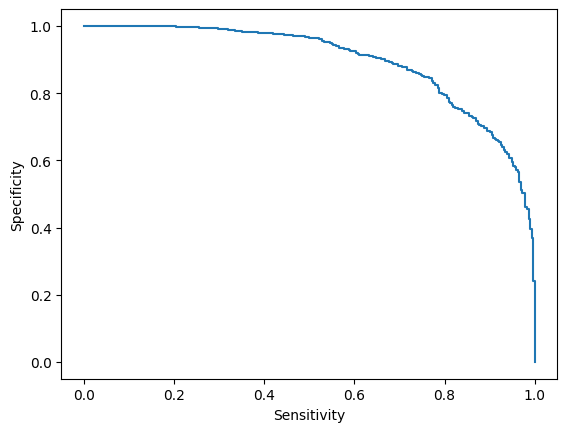

AUC score is 0.8953826192423772


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_probs = []

    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)

        true_labels.extend(np.argmax(y_batch_true, axis=1))
        predicted_probs.extend(y_batch_pred)

    return np.array(true_labels), np.array(predicted_probs)

y_true, y_pred = get_true_and_predicted_labels(model, valid_generator)

# Create binary scores for malignant and benign classes
benign_score = y_pred[:, ~np.isin(np.arange(y_pred.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.show()

print("AUC score is " + str(auc_score))

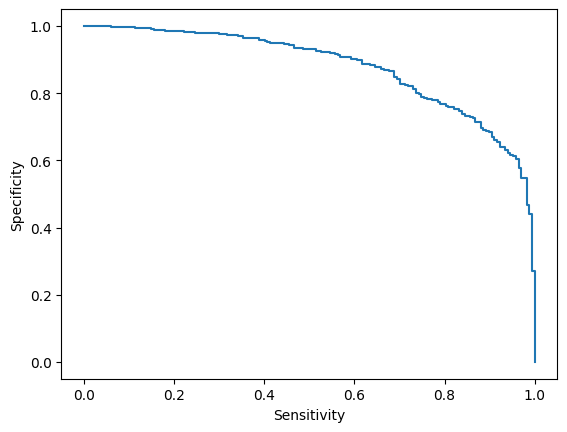

AUC score is 0.8785073987214438


In [ ]:
# Get class indices for 'mel' and 'nv' classes
mel_class_index = valid_generator.class_indices['mel']
nv_class_index = valid_generator.class_indices['nv']

# Filter samples belonging to 'mel' and 'nv' classes
mel_nv_indices = np.where((y_true == mel_class_index) | (y_true == nv_class_index))
y_true_filtered = y_true[mel_nv_indices]
y_pred_filtered = y_pred[mel_nv_indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score_mel_nv = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth_mel_nv = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth_mel_nv, mal_score_mel_nv)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth_mel_nv, mal_score_mel_nv, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.show()

print("AUC score is " + str(auc_score))

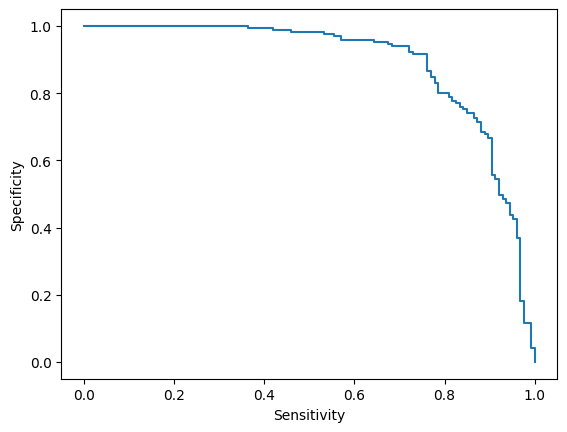

AUC score is 0.8907166907166907


In [ ]:
# Get class indices for 'bkl', 'akiec' and 'bcc' classes
bkl_class_index = valid_generator.class_indices['bkl']
akiec_class_index = valid_generator.class_indices['akiec']
bcc_class_index = valid_generator.class_indices['bcc']

# Filter samples belonging to 'bkl', 'akiec' and 'bcc' classes
indices = np.where((y_true == bkl_class_index) | 
                   (y_true == akiec_class_index) | (y_true == bcc_class_index))
y_true_filtered = y_true[indices]
y_pred_filtered = y_pred[indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.show()

print("AUC score is " + str(auc_score))

In [ ]:
import numpy as np
import scipy.stats as st
from sklearn.metrics import accuracy_score

def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_labels = []
    
    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)
        y_batch_true_labels = np.argmax(y_batch_true, axis=1)
        y_batch_pred_labels = np.argmax(y_batch_pred, axis=1)
        
        true_labels.extend(y_batch_true_labels)
        predicted_labels.extend(y_batch_pred_labels)
    
    return np.array(true_labels), np.array(predicted_labels)

def compute_accuracy_and_confidence_interval(y_true, y_pred, alpha=0.95):
    accuracy = accuracy_score(y_true, y_pred)
    n = len(y_true)
    z = st.norm.ppf(1 - (1 - alpha) / 2)
    confidence_interval = z * np.sqrt(accuracy * (1 - accuracy) / n)
    return accuracy, (accuracy - confidence_interval, accuracy + confidence_interval)

# Get the true and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(model, valid_generator)

# Get the malignant class indices
malignant_indices = [valid_generator.class_indices[cls] for cls in ['akiec', 'bcc', 'mel']]

# Convert the true and predicted labels to binary (benign/malignant)
true_labels_binary = np.array([1 if label in malignant_indices else 0 for label in true_labels])
predicted_labels_binary = np.array([1 if label in malignant_indices else 0 for label in predicted_labels])

# Compute the two-way accuracy and confidence interval
two_way_accuracy, two_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels_binary, predicted_labels_binary)
print(f"Two-way accuracy: {two_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {two_way_confidence_interval[0] * 100:.2f}% - {two_way_confidence_interval[1] * 100:.2f}%")

# Compute the seven-way accuracy and confidence interval
seven_way_accuracy, seven_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels, predicted_labels)
print(f"Seven-way accuracy: {seven_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {seven_way_confidence_interval[0] * 100:.2f}% - {seven_way_confidence_interval[1] * 100:.2f}%")

1/1 [==============================] - 0s 46ms/step
Two-way accuracy: 82.70%
Confidence interval: 80.79% - 84.61%
Seven-way accuracy: 72.12%
Confidence interval: 69.86% - 74.39%


In [ ]:
import pandas as pd

# Load the CSV file
metadata_test = pd.read_csv('/content/drive/My Drive/Project/archive/ISIC2018_Task3_Test_GroundTruth.csv')

# Define image directories
test_dir = '/content/drive/My Drive/Project/archive/ISIC2018_Task3_Test_Input'

# Rename the 'image' column to 'image_id' and add the '.jpg' extension
metadata_test['image_id'] = metadata_test['image'] + '.jpg'
metadata_test.drop(columns=['image'], inplace=True)

# Create a new column 'image_path' with the complete path to each image file
metadata_test['image_path'] = metadata_test['image_id'].apply(lambda x: os.path.join(test_dir, x))

# Convert the one-hot encoded class columns to numeric values
class_columns = metadata_test.columns[:-1]
metadata_test[class_columns] = metadata_test[class_columns].apply(pd.to_numeric, errors='coerce')

# Find the class name (column name) with the highest value (one-hot encoding) and store it in a new column 'dx'
metadata_test['dx'] = metadata_test[class_columns].idxmax(axis=1)

# Convert the class names in 'dx' column to lowercase
metadata_test['dx'] = metadata_test['dx'].str.lower()

metadata_test.drop(columns=['image_id'], inplace=True)

# Define image generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=metadata_test,
    directory=test_dir,
    x_col='image_path',
    y_col='dx',
    target_size=(299, 299),
    batch_size=batch_size,
    shuffle=False
)

Found 1512 validated image filenames belonging to 7 classes.


1/1 [==============================] - 1s 1s/step


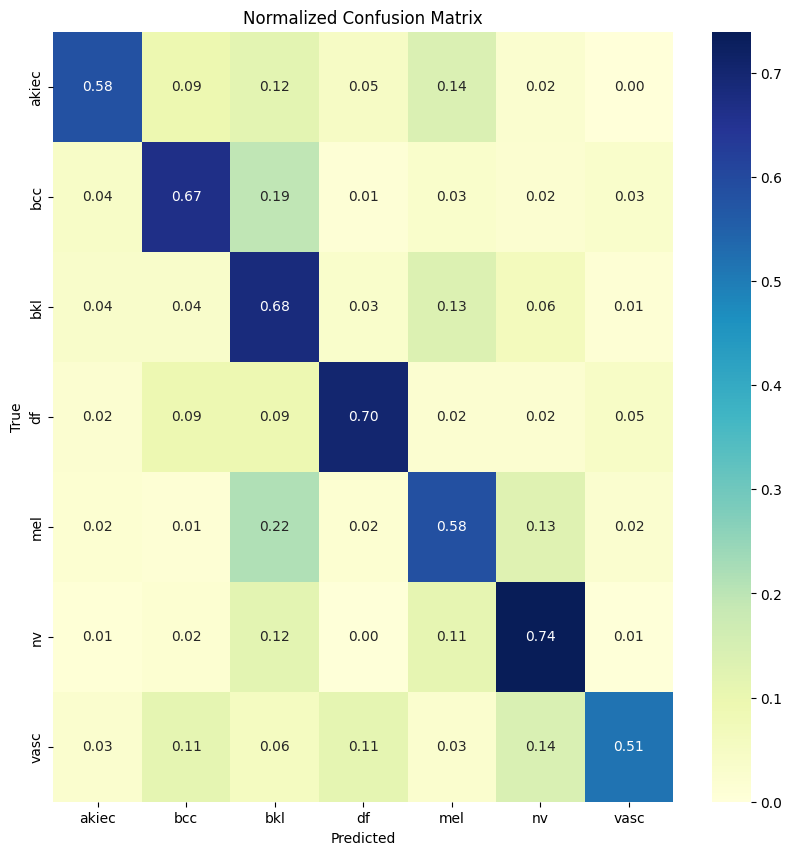

In [ ]:
# Get the true and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(model, test_generator)

# Use the class_indices object from the test_generator
class_labels = {i: label for label, i in test_generator.class_indices.items()}

cm = confusion_matrix(true_labels, predicted_labels)
normalized_cm = normalize_confusion_matrix(cm)

plt.figure(figsize=(10, 10))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 34ms/step


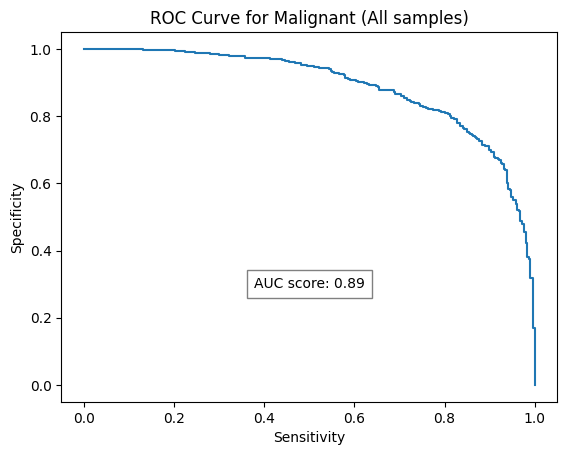

AUC score is 0.8884182356359901


In [ ]:
def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_probs = []

    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)

        true_labels.extend(np.argmax(y_batch_true, axis=1))
        predicted_probs.extend(y_batch_pred)

    return np.array(true_labels), np.array(predicted_probs)

y_true, y_pred = get_true_and_predicted_labels(model, test_generator)

# Create binary scores for malignant and benign classes
benign_score = y_pred[:, ~np.isin(np.arange(y_pred.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Malignant (All samples)")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))
plt.show()

print("AUC score is " + str(auc_score))

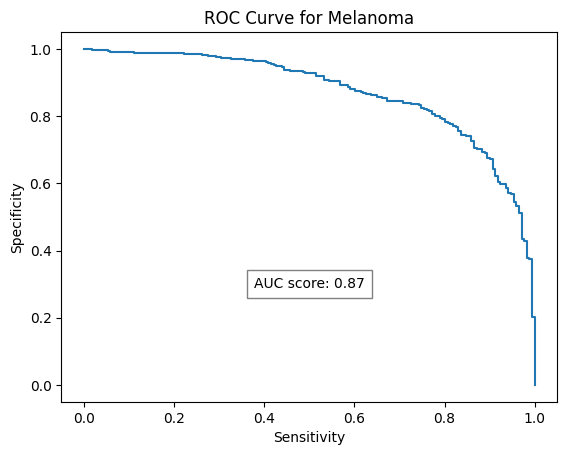

In [ ]:
# Get class indices for 'mel' and 'nv' classes
mel_class_index = test_generator.class_indices['mel']
nv_class_index = test_generator.class_indices['nv']

# Filter samples belonging to 'mel' and 'nv' classes
mel_nv_indices = np.where((y_true == mel_class_index) | (y_true == nv_class_index))
y_true_filtered = y_true[mel_nv_indices]
y_pred_filtered = y_pred[mel_nv_indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score_mel_nv = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth_mel_nv = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth_mel_nv, mal_score_mel_nv)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth_mel_nv, mal_score_mel_nv, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Melanoma")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))
plt.show()

Text(0.5, 0.3, 'AUC score: 0.89')

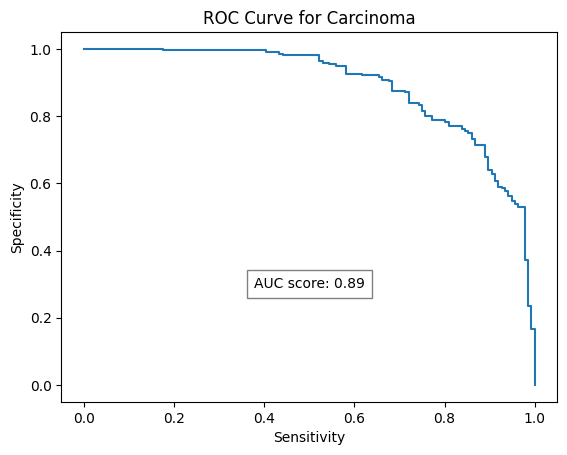

In [ ]:
# Get class indices for 'bkl', 'akiec' and 'bcc' classes
bkl_class_index = test_generator.class_indices['bkl']
akiec_class_index = test_generator.class_indices['akiec']
bcc_class_index = test_generator.class_indices['bcc']

# Filter samples belonging to 'bkl', 'akiec' and 'bcc' classes
indices = np.where((y_true == bkl_class_index) | 
                   (y_true == akiec_class_index) | (y_true == bcc_class_index))
y_true_filtered = y_true[indices]
y_pred_filtered = y_pred[indices]

# Create binary scores for malignant and benign classes
benign_score = y_pred_filtered[:, ~np.isin(np.arange(y_pred_filtered.shape[1]), malignant_classes_indices)].sum(axis=1)
mal_score = y_pred_filtered[:, malignant_classes_indices].sum(axis=1)

binary_truth = np.array([1 if label in malignant_classes_indices else 0 for label in y_true_filtered])

# Calculate the AUC
auc_score = roc_auc_score(binary_truth, mal_score)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(binary_truth, mal_score, pos_label=1)
sensitivity = tpr
specificity = 1 - fpr

# Plot the ROC curve
plt.plot(sensitivity, specificity)
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("ROC Curve for Carcinoma")
plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))

In [ ]:
def get_true_and_predicted_labels(model, generator):
    true_labels = []
    predicted_labels = []
    
    for i in range(generator.__len__()):
        X_batch, y_batch_true = generator.__getitem__(i)
        y_batch_pred = model.predict(X_batch)
        y_batch_true_labels = np.argmax(y_batch_true, axis=1)
        y_batch_pred_labels = np.argmax(y_batch_pred, axis=1)
        
        true_labels.extend(y_batch_true_labels)
        predicted_labels.extend(y_batch_pred_labels)
    
    return np.array(true_labels), np.array(predicted_labels)

def compute_accuracy_and_confidence_interval(y_true, y_pred, alpha=0.95):
    accuracy = accuracy_score(y_true, y_pred)
    n = len(y_true)
    z = st.norm.ppf(1 - (1 - alpha) / 2)
    confidence_interval = z * np.sqrt(accuracy * (1 - accuracy) / n)
    return accuracy, (accuracy - confidence_interval, accuracy + confidence_interval)

# Get the true and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(model, test_generator)

# Get the malignant class indices
malignant_indices = [test_generator.class_indices[cls] for cls in ['akiec', 'bcc', 'mel']]

# Convert the true and predicted labels to binary (benign/malignant)
true_labels_binary = np.array([1 if label in malignant_indices else 0 for label in true_labels])
predicted_labels_binary = np.array([1 if label in malignant_indices else 0 for label in predicted_labels])

# Compute the two-way accuracy and confidence interval
two_way_accuracy, two_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels_binary, predicted_labels_binary)
print(f"Two-way accuracy: {two_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {two_way_confidence_interval[0] * 100:.2f}% - {two_way_confidence_interval[1] * 100:.2f}%")

# Compute the seven-way accuracy and confidence interval
seven_way_accuracy, seven_way_confidence_interval = compute_accuracy_and_confidence_interval(true_labels, predicted_labels)
print(f"Seven-way accuracy: {seven_way_accuracy * 100:.2f}%")
print(f"Confidence interval: {seven_way_confidence_interval[0] * 100:.2f}% - {seven_way_confidence_interval[1] * 100:.2f}%")

1/1 [==============================] - 0s 31ms/step
Two-way accuracy: 81.68%
Confidence interval: 79.73% - 83.63%
Seven-way accuracy: 69.84%
Confidence interval: 67.53% - 72.15%
